In [ ]:
'''
Date: 26th June 2021
Author: Jeffrey N. A. Aryee


*Description*
This is a simple code that estimates the number of Rnnmm events using the CHIRPS rainfall data. it can however be deployed 
on any other dataset.

Detailed description on the extreme_rain_events function is provided in 2 cells below this line.
Output are either as (i) number of events or (ii) rainfall amount produced from such events.

The final cell quantifies the number of Rnnmm events as a percentage of rainy days.
'''

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import os
from os.path import basename
import cartopy.crs as ccrs
from cartopy import feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

C:\Users\HP\Anaconda3\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
def extreme_rain_events(data, descriptor, thresh, event_desc=None):
    '''
    The function measures the count of extreme rainfall events based on 2 main methods. By setting the event_desc parameter 
    to 'accum', you get the rainfall accummulation during those events.
    1. The fixed-value threshold approach (eg. RR20mm), for rain events greater or equal to 20mm, etc.
    The threshold can be modified to suit. eg. RR50mm, etc.
    
    2. Percentile-based extreme events quantification. This is based on generating the percentiles as thresholds for
    determining rainfall extreme events. The method then measures the individaul events against the threshold, pulling out events greater
    or equal to the percentile thresholds.
    
    For each method, the individual counts of valid events are substituted with a value of 1 to allow for simple aggregation as the total number 
    of extreme events per given period.
    
    
        data represents the given data to parse into the function.
        
        descriptor - either 'value' or 'percentile', depending on what approach is to be used.
        
        thresh - denotes the threshold for identifying extreme events. For value descripton, eg. R20mm, thresh is set to 20 and for percentiles where a threshold
        of say 90% is to be used, then thresh of 90 will be passed into the function.
    
        event_desc - variable to pass for either the accumulated rains during extreme events ('accum'), or leaving as blank for the count of extreme rain events.
    
    #N/B: Using the Percentile approach on precipitation extremes, interestingly, produce rather questionnable result.
    #It is likely to work better however with temperature datasets, although this is yet to be evaluated with the temperature datasets.
    '''
    if descriptor=='value' or descriptor=='v':
        tmp=data.where(data>=thresh, 0)  #Create temporary dataset of all non-extreme events as zeros, leaving the extreme rain values.
        if event_desc=='accum':
            events=tmp
        else:
            events=tmp.where(tmp<thresh, 1)
    elif descriptor=='percentile' or descriptor=='p':
        if 1<thresh<100:
            perc=data.reduce(np.nanpercentile, q=thresh, dim='time')  ###Setting percentiles as extreme threshold values.
            tmp=data.where(np.isnan(data)==False,0).where(data>perc, 0) #
            if event_desc=='accum':
                events=tmp
            else:
                events=tmp.where(tmp<=perc, 1)
                events=events.where(np.isnan(perc)==False, np.nan)
            
        else:
            print('Percentile out of range.')
            events=[]
            
    else:
        print("Wrong Descriptor. Should be either 'value (v)' or 'percentile (p)'")
        events=[]
        while True:
            break
    try:
        if event_desc!='accum':
            events=events.rename('events')
    except:
        pass
    return events
    

    
     
#Code to extract Data for a particular season.
def seasonal_select(month,x,y):  
    return (month >= x) & (month <= y)




#Function to add plot_extras and reduce code lines
def plot_extras(ax):
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    #ax.set_extent([])
    gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.xlabels_top = False; gl.ylabels_left = True; gl.ylabels_right=False; gl.xlines = True
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'black', 'weight': 'bold', 'rotation':90}
    gl.ylabel_style = {'color': 'black', 'weight': 'bold'}
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.add_feature(cf.OCEAN, facecolor='white')    

In [3]:
#### Items to configure / set
path='/gws/pw/j05/cop26_hackathons/leeds/CHIRPS/'
dataset='W_Africa_Chirps.nc'
file=glob.glob(os.path.join(path,dataset))
file=file[0]

In [5]:
#Reading the Data
CHIRPS=xr.open_dataset(file)#.sel(longitude=np.arange(-20,20,0.5),latitude=np.arange(-10,30,0.5),method='nearest')#.sel(time=slice("1980-01-01", "2019-12-31"))
Data=CHIRPS.precip
Data=Data.where(Data<1000,np.nan)  #Tweak to remove missing data over the ocean.
Summer_Data= Data.sel(time=seasonal_select(Data['time.month'],5,9))

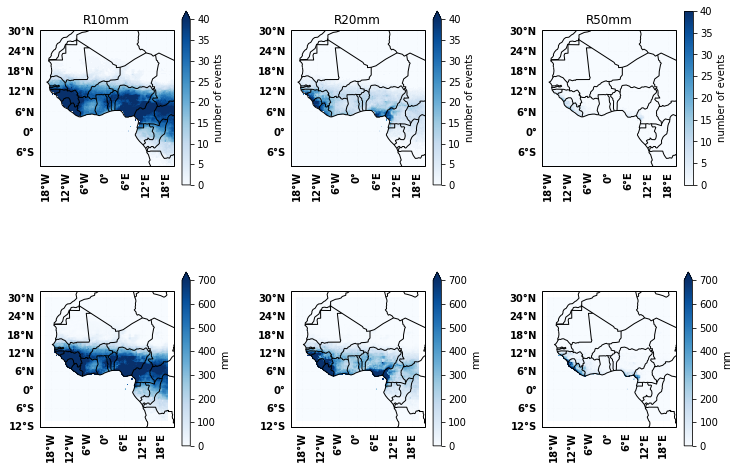

In [6]:
#### Visualization of Extremes (Spatial Plot)
extreme_rain_indices=[10,20,50]
fig=plt.figure(figsize=(12,8))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
nrows=2 #number of plot rows
for index,thresh_val in enumerate(extreme_rain_indices):
    ##### Upper Panel Subplots
    '''
    Counts of extreme events per year.
    '''
    ax = fig.add_subplot(nrows,len(extreme_rain_indices),index+1, projection=ccrs.PlateCarree())
    Extreme_events=extreme_rain_events(Summer_Data,'value',thresh_val)
    Extreme_events.groupby('time.year').sum('time').mean('year').astype(int).rename('number of events').plot.imshow(vmin=0, vmax=40, cmap='Blues')
    plot_extras(ax)
    ax.set_title('R'+str(thresh_val)+'mm')
    
    
    ### Lower Panel Subplots 
    '''
    Rainfall amount for various extreme events within the MJJAS season. These have been climatologically-averaged.
    '''
    ax = fig.add_subplot(nrows,len(extreme_rain_indices),len(extreme_rain_indices)+index+1, projection=ccrs.PlateCarree())
    Extreme_events=extreme_rain_events(Summer_Data,'value',thresh_val,'accum')
    Extreme_events.groupby('time.year').sum('time').mean('year').astype(int).rename('mm').plot(vmin=0, vmax=700, cmap='Blues')#.imshow()
    plot_extras(ax)
    ax.set_title('')
    
plt.savefig('WA_RNNmm-based_extreme_events.png')

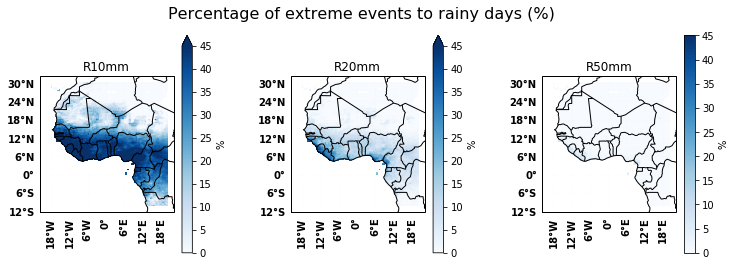

In [7]:
#Proportion of extreme events to rainy days (Spatial Plot)
Rainy_Days=Summer_Data.where(Summer_Data>1)

extreme_rain_indices=[10,20,50]
fig=plt.figure(figsize=(12,4))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Percentage of extreme events to rainy days (%) \n', fontsize=16)
for index,thresh_val in enumerate(extreme_rain_indices):
    ##### Visualization of Rainfall Accumulated during Extreme Events
    ax = fig.add_subplot(1,len(extreme_rain_indices),index+1, projection=ccrs.PlateCarree())
    Extreme_events=extreme_rain_events(Summer_Data,'value',thresh_val)
    ((Extreme_events.sum('time')/Rainy_Days.count('time'))*100).rename('%').plot(vmin=0, vmax=45, cmap='Blues')#'Blues')#, cmap='RdBu_r')
    #Extreme_events.groupby('time.year').sum('time').mean('year').astype(int).plot.imshow(vmin=0, vmax=40)
    plot_extras(ax)
    #ax.set_extent([-20,20,-10,30])
    ax.set_title('R'+str(thresh_val)+'mm')
    
plt.savefig('WA_Spatial_percentage_of_extreme_events_to_rainy_days.png')

In [ ]:
'''
This section produces a timeseries of annual counts of extreme events (based on set values eg. R10mm, R20mm, R50mm) as a 
ratio of rainy days, expressed in percentage (%).  [Time series Plot]
'''
extreme_rain_indices=[10,20,50]
fig=plt.figure(figsize=(14,5))
fig.subplots_adjust(wspace=0.5)
fig.suptitle('Percentage of extreme events to rainy days (%) \n', fontsize=16)
for index,thresh_val in enumerate(extreme_rain_indices):
    ax = fig.add_subplot(1,len(extreme_rain_indices),index+1)
    Extreme_events=extreme_rain_events(Summer_Data,'value',thresh_val)
    extreme_data_ratio=((Extreme_events.resample(time='1M').sum('time')/Rainy_Days.resample(time='1M').count('time'))*100).groupby('time.year').mean('time').mean(['longitude','latitude']).rename('%')
    extreme_data_ratio.plot(label=r'$\mu$ = '+str(int(extreme_data_ratio.mean().values))+'%')
    plt.legend(handlelength=0, handletextpad=-0.1, facecolor='red', fontsize=13)
    ax.set_title('R'+str(thresh_val)+'mm')

plt.savefig('WA_Timeseries_percentage_of_extreme_events_to_rainy_days.png')